Очень часто в задачах классификации необходимо правильно выбрать отсечку. В данном ноутбуке будет рассмотрен один из вариантов решения подобной задачи.

Вкратце: необходимо выбрать значение вероятности, при которой будет достигаться значение precision не ниже указанного порога + максимальное значение recall (Если несколько отсечек удовлетворяет этим условиям, то берется наибольшая из них).

Данные и модель могут быть абсолютно любыми, однако в нашем случае будет использоваться предобработанный датасет о крушении Титаника + Логистическая регрессия. Они взяты исключительно ради примера, внимание стоит уделить именно алгоритму поиска отсечки

In [6]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('titanic_example_df.csv')
X = df.drop('Survived', axis = 1).values
y_true = df['Survived'].values
classifier = LogisticRegression().fit(X, y_true)
y_prob = classifier.predict_proba(X)[:, 1]

# x = zip(y_true, y_prob)
# xs = sorted(x, key = lambda tup: tup[1])[::-1]
# y_true = [x[0] for x in xs]
# y_prob = [x[1] for x in xs]

# y_true = np.array(y_true)
# y_prob = np.array(y_prob)

Алгоритм:
1) Для каждой вероятности рассчитать метрики precision и recall;
2) Удалить все записи, значение точности которых меньше указанного порога;
3) Выбрать то значение отсечки, которое имеет наибольший recall + является максимальной среди всех значений вероятности с подобной полнотой

In [7]:
min_precision = 0.8

def custom_pr_curve(y_true, y_prob):

    desc_score_idx = np.argsort(y_prob)[::-1]
    y_prob = y_prob[desc_score_idx]
    y_true = y_true[desc_score_idx]

    precision = np.zeros_like(y_true, dtype = np.float64)
    recall = np.zeros_like(y_true, dtype = np.float64)

    tp = 0
    fp = 0
    fn = np.sum(y_true == 1)

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
        
        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)

    return precision, recall, y_prob

precision, recall, threshold = custom_pr_curve(y_true, y_prob)

precision_values_df = pd.DataFrame({
    'proba': threshold,
    'precision': precision,
    'recall': recall
})

precision_values_df

,proba,precision,recall
0,0.999362,1.000000,0.002924
1,0.997957,1.000000,0.005848
2,0.997399,1.000000,0.008772
3,0.997084,1.000000,0.011696
4,0.996840,1.000000,0.014620
...,...,...,...
886,0.006413,0.385569,1.000000
887,0.006413,0.385135,1.000000
888,0.001263,0.384702,1.000000
889,0.000970,0.384270,1.000000


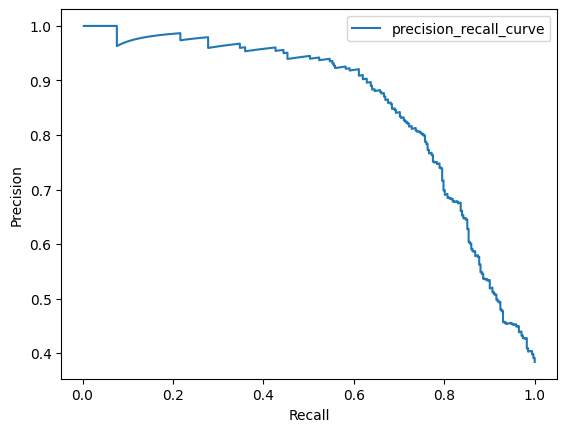

In [20]:
# Визуализация полученных результатов

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot(recall, precision, label = 'precision_recall_curve')
plt.legend();

In [9]:
precision_values_df[precision_values_df['precision'] >= min_precision].sort_values(['recall', 'proba'], ascending = [False, False])

,proba,precision,recall
321,0.386240,0.801242,0.754386
319,0.392910,0.803125,0.751462
320,0.392149,0.800623,0.751462
317,0.399379,0.805031,0.748538
318,0.395861,0.802508,0.748538
...,...,...,...
4,0.996840,1.000000,0.014620
3,0.997084,1.000000,0.011696
2,0.997399,1.000000,0.008772
1,0.997957,1.000000,0.005848


In [11]:
threshold_prob, max_recall = precision_values_df[precision_values_df['precision'] >= min_precision].sort_values(['recall', 'proba'], ascending = [False, False])[['proba', 'recall']].head(1).values[0]
threshold_prob, max_recall

(0.3862396903619079, 0.7543859649122807)

Абсолютно аналогичным образом можно поступить в случае, если вместо precision будет использоваться метрика specificity

In [12]:
min_specificity = 0.8

def custom_sr_curve(y_true, y_prob):

    desc_score_idx = np.argsort(y_prob)[::-1]
    y_prob = y_prob[desc_score_idx]
    y_true = y_true[desc_score_idx]

    specificity = np.zeros_like(y_true, dtype = np.float64)
    recall = np.zeros_like(y_true, dtype = np.float64)

    tp = 0
    fp = 0
    fn = np.sum(y_true == 1)
    tn = np.sum(y_true == 0)

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        specificity[i] = tn / (tn + fp)
        recall[i] = tp / (tp + fn)

    return specificity, recall, y_prob

specificity, recall, threshold = custom_sr_curve(y_true, y_prob)

specificity_values_df = pd.DataFrame({
    'proba': threshold,
    'specificity': specificity,
    'recall': recall
})

specificity_values_df

,proba,specificity,recall
0,0.999362,1.000000,0.002924
1,0.997957,1.000000,0.005848
2,0.997399,1.000000,0.008772
3,0.997084,1.000000,0.011696
4,0.996840,1.000000,0.014620
...,...,...,...
886,0.006413,0.007286,1.000000
887,0.006413,0.005464,1.000000
888,0.001263,0.003643,1.000000
889,0.000970,0.001821,1.000000


In [13]:
specificity_values_df[specificity_values_df['specificity'] >= min_specificity].sort_values(['recall', 'proba'], ascending = [False, False])

,proba,specificity,recall
380,0.277907,0.803279,0.798246
381,0.277574,0.801457,0.798246
367,0.290076,0.825137,0.795322
368,0.289675,0.823315,0.795322
369,0.289597,0.821494,0.795322
...,...,...,...
4,0.996840,1.000000,0.014620
3,0.997084,1.000000,0.011696
2,0.997399,1.000000,0.008772
1,0.997957,1.000000,0.005848


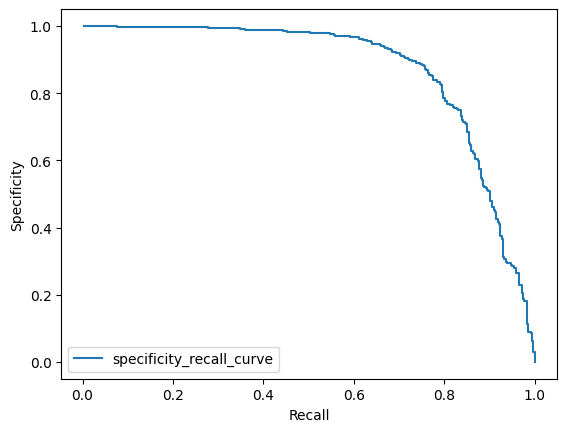

In [21]:
# Визуализация полученных результатов

plt.xlabel('Recall')
plt.ylabel('Specificity')

plt.plot(recall, specificity, label = 'specificity_recall_curve')
plt.legend();

In [14]:
threshold_prob, max_recall = specificity_values_df[specificity_values_df['specificity'] >= min_specificity].sort_values(['recall', 'proba'], ascending = [False, False])[['proba', 'recall']].head(1).values[0]
threshold_prob, max_recall

(0.27790727007249205, 0.7982456140350878)

Сравнение поведения двух кривых

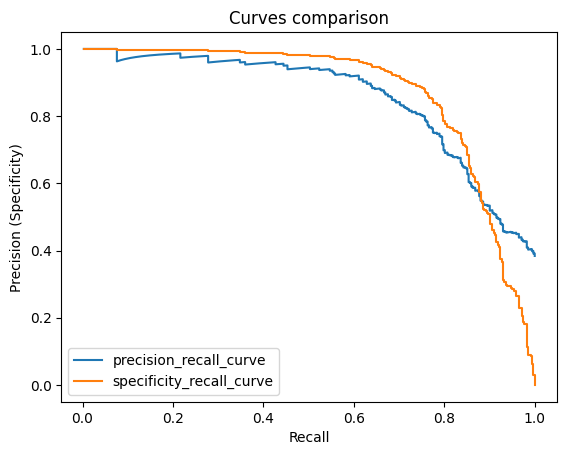

In [17]:
plt.title('Curves comparison')
plt.xlabel('Recall')
plt.ylabel('Precision (Specificity)')

plt.plot(recall, precision, label = 'precision_recall_curve')
plt.plot(recall, specificity, label = 'specificity_recall_curve')
plt.legend()
plt.show();